# Train an autoencoder on the MNIST dataset, trying to keep the embedding size no larger than 128. 

Generate embeddings for a thousand objects from the training sample (as in the seminar), train a Random Forest on these embeddings. Achieve an accuracy of over 90%.

Create embeddings for 1,000 objects from the training sample; the tensor with them should have a dimension of (1,000,N), where N≤128. We will train a Random Forest from the scikit-learn library on this tensor, namely RandomForestClassifier(random_state=0). Then we will check the quality of your embeddings for the test sample, submit them as well. The tensor with embeddings for the test sample should have dimensions (10000,N). The accuracy of our trained random forest should be greater than 90% on the test embeddings.

To submit all embeddings correctly, use this function:

```python
def save_embeddings(x_train, y_train, x_valid, y_valid):
    assert x_train.shape[0] == 1000
    assert x_valid.shape[0] == 10000
    
    assert y_train.shape[0] == 1000
    assert y_valid.shape[0] == 10000

    torch.save(
        {
            'x_train': x_train,
            'y_train': y_train,
            'x_valid': x_valid,
            'y_valid': y_valid
        },
        'embeddings.pt'
    )

```

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as T

from torch.utils.data import DataLoader
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam
import numpy as np
from PIL import Image
import math

In [2]:
mnist_transforms = T.Compose(
    [
        T.Resize((64, 64)),
        T.ToTensor(),
    ]
)

train_dataset = MNIST('mnist', train=True, transform=mnist_transforms, download=True)
valid_dataset = MNIST('mnist', train=False, transform=mnist_transforms, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 37921863.82it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 1027174.31it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 9826626.65it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2769374.73it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [3]:
from torchvision.utils import make_grid

def train(model):
    model.train()

    train_loss = 0

    for x, _ in tqdm(train_loader, desc='Train'):
        x = x.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, x)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)

    return train_loss


@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0

    for x, _ in tqdm(loader, desc='Evaluation'):
        x = x.to(device)

        output = model(x)

        loss = loss_fn(output, x)

        total_loss += loss.item()

    total_loss /= len(loader)

    return total_loss


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()


@torch.inference_mode()
def visualize(model, xs):
    model.eval()

    to_pil = T.ToPILImage()

    outputs = model(xs.to(device)).cpu()
    
    plt.figure(figsize=(20, 4))
    
    plt.imshow(
        to_pil(
            torch.cat(
                (
                    make_grid(xs[:10], nrow=10, pad_value=1),
                    make_grid(outputs[:10], nrow=10, pad_value=1)
                ),
                dim=1
            )
        )
    )
    
    plt.axis('off')

    plt.show()


def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        train_loss = train(model)
        valid_loss = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        clear_output(wait=True)
        
        visualize(model, next(iter(valid_loader))[0])

        plot_stats(
            train_loss_history, valid_loss_history,
            title
        )

In [4]:
class Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, upsample: bool = False):
        super().__init__()
        self.upsample = upsample
        self.dropout = nn.Dropout2d(0.1)
        
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=1,
            padding_mode='reflect',
            bias=False
        )
        self.norm = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        if self.upsample:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False, recompute_scale_factor=False)

        return self.act(self.dropout(self.norm(self.conv(x))))


class AutoEncoder(nn.Module):
    def __init__(self, in_channels: int, base_block: nn.Module = Block, base_size: int = 32, num_blocks: int = 4):
        super().__init__()

        self.base_size = base_size

        # encoder creation

        encoder_blocks = []

        for i in range(num_blocks):
            encoder_blocks.append(
                base_block(
                    in_channels=base_size if i else in_channels,
                    out_channels=base_size,
                    kernel_size=3,
                    stride=2
                )
            )

        encoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=base_size,
                kernel_size=3
            ).conv
        )

        self.encoder = nn.Sequential(*encoder_blocks)  # N -> N // (2 ** num_blocks)

        # decoder creation

        decoder_blocks = []

        for i in range(num_blocks):
            decoder_blocks.append(
                base_block(
                    in_channels=base_size,
                    out_channels=base_size,
                    kernel_size=3,
                    upsample=True
                )
            )

        decoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=in_channels,
                kernel_size=3
            ).conv
        )
        decoder_blocks.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_blocks)  # N // (2 ** num_blocks) -> N

        self.flatten = nn.Flatten()

    def forward(self, x):
        # x.shape = [bs, in_channels, N, N]
        x = self.encoder(x)
        # x.shape = [bs, base_size, N // (2 ** num_blocks), N // (2 ** num_blocks)]
        x = self.decoder(x)
        # x.shape = [bs, in_channels, N, N]

        return x

    @torch.inference_mode()
    def encode(self, x):
        # x.shape = [bs, in_channels, N, N]
        return self.flatten(self.encoder(x)) # output.shape = [bs, base_size * N ** 2 / (2 ** num_blocks) ** 2]

    @torch.inference_mode()
    def decode(self, x):
        # x.shape = [bs, base_size * N ** 2 / (2 ** num_blocks) ** 2]
        latent_size = int(math.sqrt(x.shape[1] // self.base_size))

        return self.decoder(x.view(-1, self.base_size, latent_size, latent_size))  # output.shape = [bs, in_channels, N, N]

In [5]:
#!g1.1
class DenoisingBlock(Block):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, upsample: bool = False):
        super().__init__(in_channels, out_channels, kernel_size, stride, upsample)
        
        
    def forward(self, x):
        if self.upsample:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False, recompute_scale_factor=False)

        if self.training:
            x = x + torch.randn_like(x) * 0.05

        return self.act(self.dropout(self.norm(self.conv(x))))


class DenoisingAutoEncoder(AutoEncoder):
    def __init__(self, in_channels: int, base_block: nn.Module = DenoisingBlock, base_size: int = 32, num_blocks: int = 4):
        super().__init__(in_channels, base_block, base_size, num_blocks)

    def forward(self, x):
        if self.training:
            x = torch.clip(x + torch.randn_like(x) * 0.1, min=0, max=1)

        # x.shape = [bs, in_channels, N, N]
        x = self.encoder(x)
        # x.shape = [bs, base_size, N // (2 ** num_blocks), N // (2 ** num_blocks)]
        x = self.decoder(x)
        # x.shape = [bs, in_channels, N, N]

        return x

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.MSELoss()

model = DenoisingAutoEncoder(in_channels=1, base_size=32, num_blocks=5).to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

cuda:0
Tesla T4


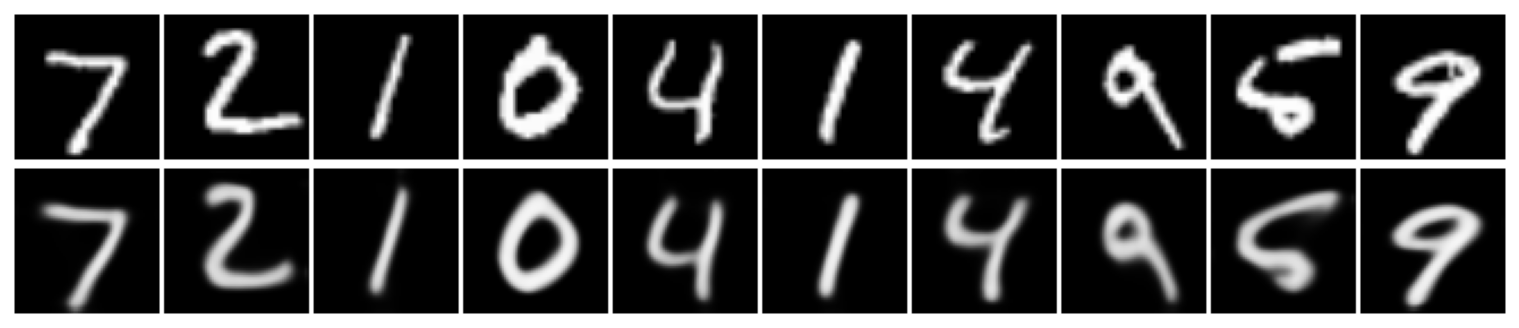

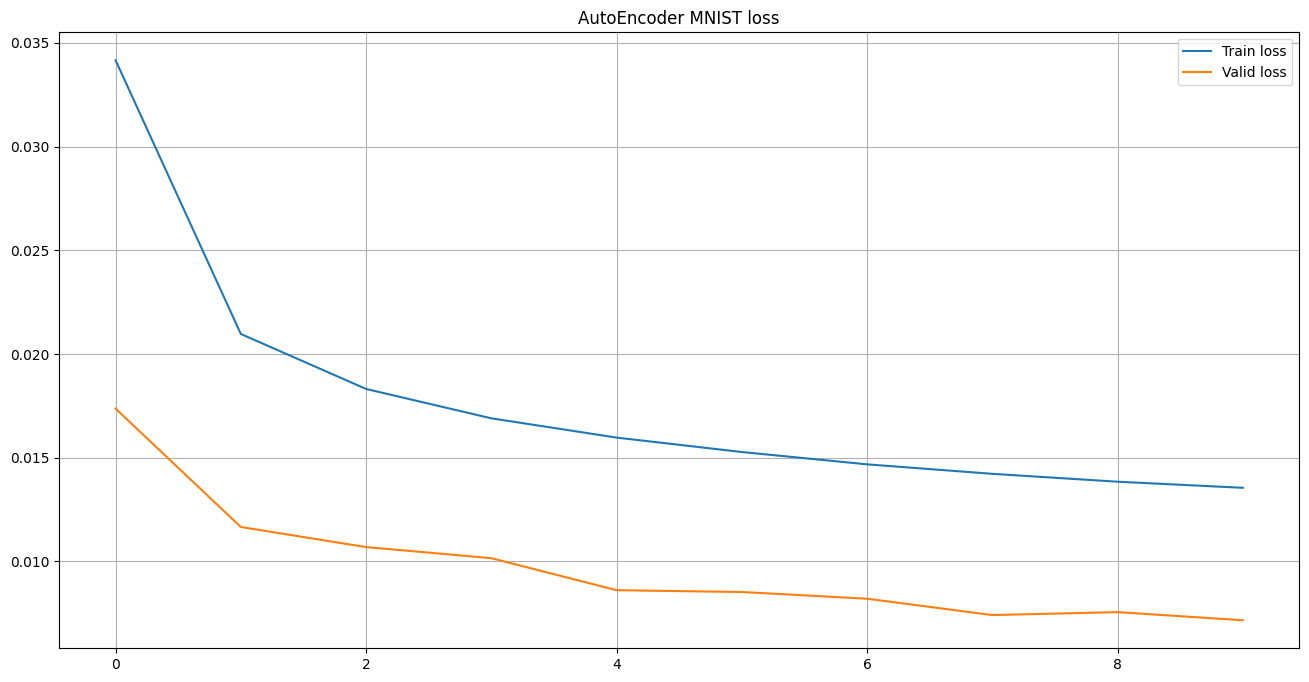

In [7]:
whole_train_valid_cycle(model, 10, 'AutoEncoder MNIST')

In [8]:
@torch.inference_mode()
def get_latent_labels(model, loader, count: int=None):
    model.eval()
    
    total = 0
    
    latent = []
    labels = []
    
    for x, y in loader:
        z = model.encode(x.to(device)).cpu()
        
        latent.append(z)
        labels.append(y)
        
        total += y.shape[0]
        
        if count is not None and total >= count:
            break
            
    latent = torch.cat(latent)[:count].numpy()
    labels = torch.cat(labels)[:count].numpy()
    
    return latent, labels

def save_embeddings(x_train, y_train, x_valid, y_valid):
    assert x_train.shape[0] == 1000
    assert x_valid.shape[0] == 10000
    
    assert y_train.shape[0] == 1000
    assert y_valid.shape[0] == 10000

    torch.save(
        {
            'x_train': x_train,
            'y_train': y_train,
            'x_valid': x_valid,
            'y_valid': y_valid
        },
        'embeddings.pt'
    )

In [9]:
x, y = get_latent_labels(model, train_loader, 1000)

x.shape, y.shape

((1000, 128), (1000,))

In [10]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(random_state=0).fit(x, y)


In [11]:
x_valid, y_valid = get_latent_labels(model, valid_loader)
(clf.predict(x_valid) == y_valid).mean()

0.9347

In [12]:
save_embeddings(x, y, x_valid, y_valid)